# AI Skilling Employee Insights Dashboard Project

**Applicant:** Crystal Ford  
**Position:** AI Skilling Data Analyst (Microsoft, Job ID 1838294)  

---

**Goal.** Analyze employee engagement, training, and sentiment data to generate insights that support AI-driven skilling programs.  
**Deliverables.** Jupyter/Colab notebook, cleaned dataset, and Power BI dashboard.  


# AI Skilling – Employee Insights (Engagement • Training • Sentiment)

**Goal.** Pull four HR-related files together, clean dates, add simple sentiment, and export a tidy file for a Power BI dashboard.

**What’s inside.**
- Merge four CSVs on a shared `EmployeeID`
- Normalize dates so time-based stuff works
- Create short example comments (generated by AI) + a basic sentiment label
- Quick EDA and a clean export for BI

**Why this exists.** The job wants someone who can turn learning data into clear, actionable insights. This notebook shows that end-to-end.

## Setup

Load the usual data stack (pandas, numpy, matplotlib). Keep it simple and readable.


## Connect to Drive

Mount Google Drive so the CSVs can be read directly from a project folder.


## Load data files

Read four CSVs:
- `employee_data` – HR master (status, division, etc.)
- `employee_engagement_survey_data` – engagement/satisfaction scores
- `recruitment_data` – applicant info mapped to IDs
- `training_and_development_data` – training events and outcomes

Print shapes and a few rows to confirm things look sane.


## Make the join key consistent

Each file used a slightly different name for the ID (`EmpID`, `Employee ID`, `Applicant ID`). Rename them all to **`EmployeeID`** so merges are straightforward.


## Merge everything

Join on `EmployeeID` using **LEFT** joins so every survey row stays in the dataset. Attach training, recruitment, and employee details wherever they exist.


In [1]:
# --- Step 1: Install / Import Packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text prep (sentiment analysis later)
import re
import string
from sklearn.model_selection import train_test_split

# --- Step 2: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Step 3: Load CSVs ---
data_path = "/content/drive/MyDrive/ai_skilling_project/data/"

employee_data = pd.read_csv(data_path + "employee_data.csv")
engagement_data = pd.read_csv(data_path + "employee_engagement_survey_data.csv")
recruitment_data = pd.read_csv(data_path + "recruitment_data.csv")
training_data = pd.read_csv(data_path + "training_and_development_data.csv")

# --- Step 4: Peek at Each ---
print("Employee Data:", employee_data.shape)
print(employee_data.head(), "\n")

print("Engagement Survey Data:", engagement_data.shape)
print(engagement_data.head(), "\n")

print("Recruitment Data:", recruitment_data.shape)
print(recruitment_data.head(), "\n")

print("Training Data:", training_data.shape)
print(training_data.head(), "\n")

# --- Clean Merge of All Four Files ---

# Step 1: Standardize the ID column names
# Each file used a slightly different name, so renamed them all to "EmployeeID"
engagement_data = engagement_data.rename(columns={'Employee ID': 'EmployeeID'})
training_data   = training_data.rename(columns={'Employee ID': 'EmployeeID'})
recruitment_data = recruitment_data.rename(columns={'Applicant ID': 'EmployeeID'})
employee_data_renamed = employee_data.rename(columns={'EmpID': 'EmployeeID'})

# Step 2: Merge the datasets
# Used LEFT joins so that every employee stays in the dataset
df = (engagement_data
      .merge(training_data, on='EmployeeID', how='left')
      .merge(recruitment_data, on='EmployeeID', how='left')
      .merge(employee_data_renamed, on='EmployeeID', how='left'))

print("Final merged dataset shape:", df.shape)
df.head()


ModuleNotFoundError: No module named 'google.colab'

## Normalize date columns

Dates came in mixed formats (e.g., `21-Sep-22`, `10-10-2022`). Convert them to real datetimes so sorting, filtering, and time trends don’t misbehave.


In [9]:
# --- Clean Up Date Columns ---

# Some of the date columns are stored as text in different formats.
# Converting them to datetime makes them easier to work with (sorting, filtering, time-based analysis).

# Engagement survey dates
if "Survey Date" in df.columns:
    df["SurveyDate"] = pd.to_datetime(df["Survey Date"], errors="coerce", dayfirst=True)

# Training dates
if "Training Date" in df.columns:
    df["TrainingDate"] = pd.to_datetime(df["Training Date"], errors="coerce", dayfirst=True)

# Recruitment application dates
if "Application Date" in df.columns:
    df["ApplicationDate"] = pd.to_datetime(df["Application Date"], errors="coerce", dayfirst=True)

# Employee start and exit dates
if "StartDate" in df.columns:
    df["StartDate"] = pd.to_datetime(df["StartDate"], errors="coerce", dayfirst=True)
if "ExitDate" in df.columns:
    df["ExitDate"] = pd.to_datetime(df["ExitDate"], errors="coerce", dayfirst=True)

df[["SurveyDate", "TrainingDate", "ApplicationDate", "StartDate", "ExitDate"]].head()


/tmp/ipython-input-968360826.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TrainingDate"] = pd.to_datetime(df["Training Date"], errors="coerce", dayfirst=True)
/tmp/ipython-input-968360826.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ApplicationDate"] = pd.to_datetime(df["Application Date"], errors="coerce", dayfirst=True)
/tmp/ipython-input-968360826.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["StartDate"] = pd.to_datetime(df["StartDate"], errors="coerce", dayfirst=True)
/tmp/ipython-input-968360826.py:22: UserWarning: Could not infer for

,SurveyDate,TrainingDate,ApplicationDate,StartDate,ExitDate
0,2022-10-10,2022-09-21,2023-06-03,2019-08-29,NaT
1,2023-08-03,2023-07-19,2023-05-15,2022-12-12,2023-05-28
2,2023-01-03,2023-02-24,2023-08-04,2023-03-08,2023-03-15
3,2023-07-30,2023-01-12,2023-07-28,2020-05-29,2021-03-05
4,2023-06-19,2023-05-12,2023-06-05,2022-09-16,NaT


## Add example comments + sentiment label

The survey file doesn’t include open-text comments. Add a tiny set of **example comments generated by AI** (positive / neutral / negative) and assign one per row based on satisfaction/engagement.  
Create a **rule-based sentiment label** from the score (≥4 = positive, ≤2 = negative, else neutral). This is just a baseline to show the text pipeline—real comments would replace these in production.


In [10]:
# --- Add Synthetic Survey Comments and Sentiment Labels ---

import numpy as np
rng = np.random.default_rng(42)  # sets a seed so results are repeatable

# Example comments generated by AI (positive, neutral, negative)
positive_comments = [
    "Loved the pacing and hands-on labs.",
    "Felt confident applying AI at work after this.",
    "Great instructor and relevant examples."
]
neutral_comments = [
    "Content was okay; could use more real-world cases.",
    "Learned a bit but some modules felt long.",
    "Decent overview; I’ll need more practice though."
]
negative_comments = [
    "Too theoretical and not applicable to my role.",
    "Platform was buggy and I got stuck often.",
    "Instructor moved too fast; materials were unclear."
]

# Create a new column of comments
# If satisfaction is high, pick a positive comment
# If satisfaction is low, pick a negative comment
# Otherwise, pick a neutral one
def make_comment(sat, eng):
    s = sat if pd.notna(sat) else eng
    try:
        s = int(s)
    except:
        return rng.choice(neutral_comments)
    if s >= 4:
        return rng.choice(positive_comments)
    elif s <= 2:
        return rng.choice(negative_comments)
    else:
        return rng.choice(neutral_comments)

df["SurveyComment"] = df.apply(lambda r: make_comment(
    r.get("Satisfaction Score"), r.get("Engagement Score")
), axis=1)

# Create a quick rule-based sentiment label
# High score = positive, low score = negative, middle = neutral
def make_label(sat, eng):
    s = sat if pd.notna(sat) else eng
    try:
        s = int(s)
    except:
        return "neutral"
    if s >= 4:
        return "positive"
    elif s <= 2:
        return "negative"
    return "neutral"

df["SentimentLabel_rule"] = df.apply(
    lambda r: make_label(r.get("Satisfaction Score"), r.get("Engagement Score")), axis=1
)

df[["Satisfaction Score", "SurveyComment", "SentimentLabel_rule"]].head()


,Satisfaction Score,SurveyComment,SentimentLabel_rule
0,5,Loved the pacing and hands-on labs.,positive
1,5,Great instructor and relevant examples.,positive
2,5,Felt confident applying AI at work after this.,positive
3,5,Felt confident applying AI at work after this.,positive
4,4,Felt confident applying AI at work after this.,positive


## Quick EDA for the dashboard

Check distribution of the sentiment label and a simple outcome view:
- Overall counts by sentiment
- Training completion rate by sentiment
- Top training programs by enrollments

These summaries feed the Power BI visuals.


## Export for BI

Save a slimmed-down CSV with the key columns used in the dashboard (IDs, dates, scores, sentiment label, training outcome, division, etc.). This file is what the Power BI report points at.


Rule-based sentiment counts:
SentimentLabel_rule
positive    1230
negative    1166
neutral      604
Name: count, dtype: int64


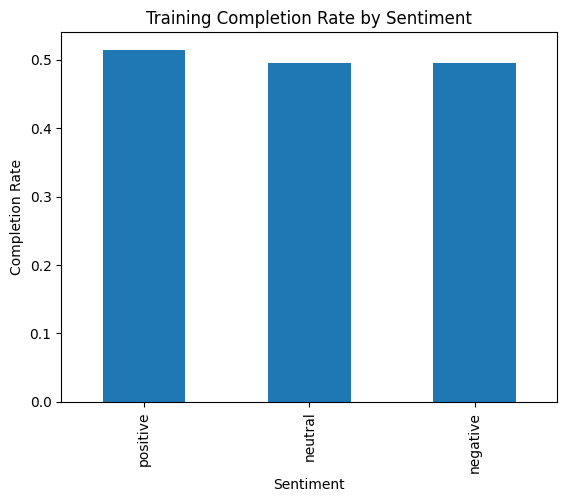

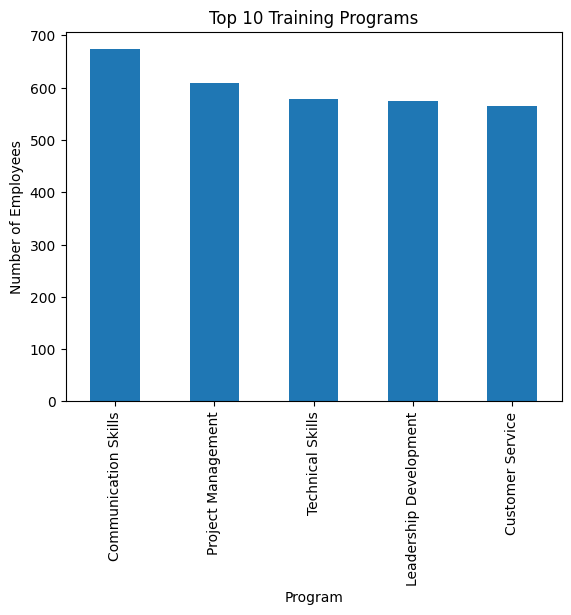

Saved: /content/drive/MyDrive/ai_skilling_project/outputs/sentiment_training.csv


In [11]:
# --- Quick EDA and Dashboard Exports ---

import matplotlib.pyplot as plt
import os

# Sentiment distribution
print("Rule-based sentiment counts:")
print(df["SentimentLabel_rule"].value_counts())

# Training completion rate by sentiment
if "TrainingCompleted" not in df.columns:
    df["TrainingCompleted"] = df["Training Outcome"].isin(["Completed","Passed"])

comp = (df.groupby("SentimentLabel_rule")["TrainingCompleted"]
          .mean()
          .sort_values(ascending=False))

comp.plot(kind="bar", title="Training Completion Rate by Sentiment")
plt.ylabel("Completion Rate")
plt.xlabel("Sentiment")
plt.show()

# Training program popularity
if "Training Program Name" in df.columns:
    (df["Training Program Name"].value_counts().head(10)
       .plot(kind="bar", title="Top 10 Training Programs"))
    plt.ylabel("Number of Employees")
    plt.xlabel("Program")
    plt.show()

# Export tidy dataset for Power BI / Tableau
out_path = "/content/drive/MyDrive/ai_skilling_project/outputs/"
os.makedirs(out_path, exist_ok=True)

keep_cols = [c for c in [
    "EmployeeID", "SurveyDate", "Engagement Score", "Satisfaction Score",
    "TrainingDate", "Training Program Name", "Training Outcome",
    "TrainingCompleted", "SurveyComment", "SentimentLabel_rule", "Division"
] if c in df.columns]

tidy = df[keep_cols].copy()
tidy.to_csv(out_path + "sentiment_training.csv", index=False)

print("Saved:", out_path + "sentiment_training.csv")


## Notes & next steps

- **Synthetic comments.** Short example comments were generated by AI to demo the text workflow since the raw dataset didn’t include free-text feedback.
- **Sentiment baseline.** A simple score-based label is used here. A trained model (e.g., LSTM or transformer) could replace it for richer analysis.
- **Join choice.** LEFT joins keep every survey row, then add training/recruitment/employee context when available.
- **Privacy.** This is mock data; in a real HR setting, privacy and Responsible AI policies would apply.

**Stretch ideas (if time later):**
- A/B style comparisons of completion before/after a program change
- Cohort analysis by division or tenure
- Model-based sentiment on real comments
